In [29]:
from tensorflow import keras
from tensorflow.keras import layers

In [94]:
res = 24

In [95]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = keras.Input(shape=(res, res, 3))
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 24, 24, 3)]       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 24, 24, 3)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               221312    
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
Total params: 239,114
Trainable params: 239,114
Non-trainable params: 0
_______________________________________________

In [112]:
# This is just a copy of the simple MNIST tutorial
# https://keras.io/examples/vision/mnist_convnet/
model_terrain = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(8, activation="softmax"),
    ]
)

model_crowns = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)


In [98]:
import os
import cv2
import numpy as np

N = 225
noise_loops = 101

training_x= np.zeros((4*noise_loops*N, res, res, 3))
terrain_y = np.zeros(4*noise_loops*N)
crowns_y = np.zeros(4*noise_loops*N)

cnt = 0
for file in os.listdir("training/"):
    tile = cv2.cvtColor(cv2.imread("training/" + file), cv2.COLOR_BGR2RGB)
    tile = cv2.resize(tile, (res, res))
    label = file.split(".")[0].split("_")

    for k in range(4):
        training_x[cnt] = tile
        terrain_y[cnt] = int(label[2])
        crowns_y[cnt] = int(label[3])
        cnt = cnt + 1
        
        for j in range(noise_loops - 1):
            tmp = tile.copy()
            tmp = tmp + np.random.normal(0, 0.1, tmp.shape)
            training_x[cnt] = tmp
            terrain_y[cnt] = int(label[2])
            crowns_y[cnt] = int(label[3])
            cnt = cnt + 1

        tile = np.rot90(tile)


Text(0.5, 1.0, '3.0')

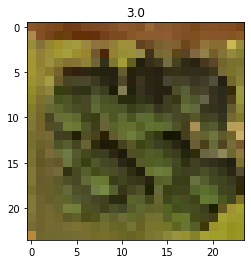

In [124]:
plt.imshow(training_x[12345].astype('uint8'))
plt.title(terrain_y[12345])

In [138]:
model_terrain.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model_crowns.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [139]:
print("Fit model on training data")
history = model_terrain.fit(
    training_x,
    terrain_y,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(training_x, terrain_y),
)

Fit model on training data
Epoch 1/5
1421/1421 [==============================] - 15s 11ms/step - loss: 0.4840 - sparse_categorical_accuracy: 0.9371 - val_loss: 4.2091e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5
1421/1421 [==============================] - 15s 10ms/step - loss: 0.1141 - sparse_categorical_accuracy: 0.9912 - val_loss: 1.7337e-09 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1421/1421 [==============================] - 15s 10ms/step - loss: 0.1145 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1421/1421 [==============================] - 15s 10ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
1421/1421 [==============================] - 15s 10ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000


In [140]:
predictions = model_terrain.predict(training_x)

In [141]:
score = model_terrain.evaluate(training_x, terrain_y, verbose=1)


2841/2841 [==============================] - 5s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000


In [142]:
score

[0.0, 1.0]

In [143]:
np.histogram(terrain_y, bins=[0,1,2,3,4,5,6,7,8])

(array([20200, 14544, 16160, 22220, 10504,  2828,  3636,   808]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

array([[0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

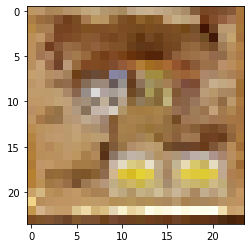

In [144]:
import matplotlib.pyplot as plt

plt.imshow(training_x[525].astype('uint8'))
model_terrain.predict(training_x[525:526])

In [145]:
model_terrain.save("models/terrain_model.keras")

In [126]:
training_x[0]

array([[[176., 131.,  55.],
        [188., 157.,  98.],
        [189., 157.,  99.],
        ...,
        [174., 150., 114.],
        [131., 106.,  76.],
        [128.,  90.,  59.]],

       [[184., 146.,  82.],
        [183., 147.,  85.],
        [188., 156.,  94.],
        ...,
        [152., 113.,  87.],
        [161., 126.,  87.],
        [100.,  59.,  32.]],

       [[182., 139.,  69.],
        [128.,  90.,  42.],
        [149., 108.,  66.],
        ...,
        [105.,  59.,  33.],
        [173., 144., 103.],
        [109.,  71.,  43.]],

       ...,

       [[168., 115.,  29.],
        [180., 136.,  72.],
        [177., 137.,  76.],
        ...,
        [172., 130.,  76.],
        [178., 141.,  84.],
        [ 36.,   9.,   5.]],

       [[177., 119.,  36.],
        [191., 152.,  89.],
        [181., 142.,  79.],
        ...,
        [178., 142.,  80.],
        [167., 132.,  80.],
        [ 23.,  11.,   6.]],

       [[167., 173.,  56.],
        [162., 172.,  49.],
        [173., 1

In [115]:
print("Fit model on training data")
history = model_crowns.fit(
    training_x,
    crowns_y,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(training_x, crowns_y),
)

Fit model on training data
Epoch 1/5
1421/1421 [==============================] - 15s 10ms/step - loss: 0.4637 - sparse_categorical_accuracy: 0.9299 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 0.9989
Epoch 2/5
1421/1421 [==============================] - 14s 10ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9903 - val_loss: 4.1355e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1421/1421 [==============================] - 14s 10ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9939 - val_loss: 1.7523e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1421/1421 [==============================] - 14s 10ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
1421/1421 [==============================] - 14s 10ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9962 - val_loss: 8.2227e-10 - val_sparse_categorical_accuracy: 1.0000


array([[5.6447051e-20, 1.6039378e-15, 1.0000000e+00, 5.7958633e-31]],
      dtype=float32)

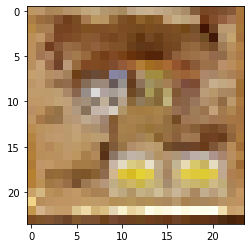

In [117]:
plt.imshow(training_x[525].astype('uint8'))
model_crowns.predict(training_x[525:526])

array([[1., 0., 0., 0.]], dtype=float32)

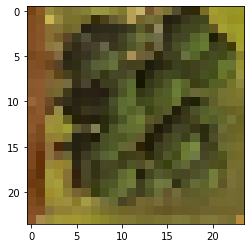

In [118]:
plt.imshow(training_x[12500].astype('uint8'))
model_crowns.predict(training_x[12500:12501])

In [120]:
model_crowns.save("models/crowns_model.keras")

In [121]:
training_x.shape

(90900, 24, 24, 3)

In [122]:
training_x.dtype

dtype('float64')